# importar pacotes

In [1]:
!pip install seaborn -U

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import PredictionErrorDisplay

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# importar dados

In [4]:
# df = pd.read_csv("C:/Users/LarissaVieiraValadão/Downloads/clean_min_data.csv").drop(['Unnamed: 0'],axis=1)
# df = pd.read_csv('C:/Users/l_v_v/Documents/GitHub/py6s_harmonize_sample/datasets/Landsat Sampling/Merged Landsat Data/merge_min_data.csv').drop(['Unnamed: 0'],axis=1)
df = pd.read_csv('/content/drive/MyDrive/CURUAI_PROCESS/merge_min_data.csv').drop(['Unnamed: 0'],axis=1)
df.columns

Index(['CHLOROPHYLL', 'CHLOROPHYLL_A', 'CHLOROPHYLL_B', 'CLOUD_COVER',
       'DEPTH_CLASS', 'DOC', 'ID', 'LATITUDE', 'LOCATION', 'LONGITUDE',
       'MISSION', 'N_TOTAL', 'N_TOTAL_DISSOLVED', 'POC', 'P_ORGANIC',
       'P_TOTAL', 'SAMPLE_SITE', 'SAMPLING_DEPTH', 'SILICA', 'SPM', 'TOC',
       'TOTAL_DEPTH', 'TURBIDITY', 'WATER_PERIOD', 'blue_max', 'blue_mean',
       'blue_median', 'blue_min', 'blue_stdDev', 'count_pixel', 'datetime',
       'dif_date_point', 'green_max', 'green_mean', 'green_median',
       'green_min', 'green_stdDev', 'img_date', 'nir_max', 'nir_mean',
       'nir_median', 'nir_min', 'nir_stdDev', 'red_max', 'red_mean',
       'red_median', 'red_min', 'red_stdDev', 'system_index',
       'dif_date_point_abs', 'satellite', 'duplicated'],
      dtype='object')

# Funções de calculo de métricas

In [5]:
def model_metrics(y_true,y_pred):
    ''' y = observed target values
    y_pred = predicted target values'''
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import explained_variance_score

    return {'r2':r2_score(y_true, y_pred),
'mae':mean_absolute_error(y_true, y_pred),
'mse':mean_squared_error(y_true, y_pred),
'mape':mean_absolute_percentage_error(y_true, y_pred),
'exp_var': explained_variance_score(y_true, y_pred)
    }

In [6]:
def cv_model_metrics(model,X,y,n_cv=5):
    ''' model = model to evaluate
    X = predictors
    y = observed target values
    cv = number of cross validations, standard is 5'''
    from sklearn.model_selection import ShuffleSplit

    cv = ShuffleSplit(n_splits=n_cv, test_size=0.15, random_state=0)
    from sklearn.model_selection import cross_val_score

    return {'r2':abs(cross_val_score(model, X, y, cv=cv,scoring='r2')).mean(),
'mae':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_error')).mean(),
'mse':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_squared_error')).mean(),
'mape':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_percentage_error')).mean(),
'exp_var': abs(cross_val_score(model, X, y, cv=cv,scoring='explained_variance')).mean()
    }

# Linear regression

In [7]:
ols = LinearRegression()

In [8]:
model_poly = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                  ('linear', LinearRegression(positive=False))])

In [9]:
model_splines = Pipeline([('poly', SplineTransformer(n_knots=5, degree=3)),
                  ('linear', LinearRegression(positive=False))])

## subset dados de SPM e de satélite

In [10]:
df_subset = df[['SPM','blue_mean',
       'green_mean',
       'nir_mean',
       'red_mean',
       'datetime',
       'WATER_PERIOD']].copy()
# retirar valores em branco
df_subset = df_subset.dropna()
df_subset.isna().sum()

SPM             0
blue_mean       0
green_mean      0
nir_mean        0
red_mean        0
datetime        0
WATER_PERIOD    0
dtype: int64

In [11]:
drop_columns_X_model = ['SPM','datetime','WATER_PERIOD']

## Polynomial NIR regression

In [12]:
# separate parameters
y = df_subset['SPM'].copy()
X = np.array(df_subset['nir_mean']).reshape(-1, 1).copy()

In [13]:
model_fit = model_poly.fit(X, y)

In [14]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [ -1289.82047993 193058.50139081]
intercept: 24.068260743973234


In [15]:
y_pred_model = model_fit.predict(X)

### Avaliação do modelo

In [16]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.7793424470569922, 'mae': 21.526140512395127, 'mse': 1118.3923357901424, 'mape': 0.5991826834492819, 'exp_var': 0.7793424470569921}


Cross validation

In [17]:
cv_metrics = cv_model_metrics(model=model_poly,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.7538958241208045, 'mae': 19.851693529182917, 'mse': 969.725471924917, 'mape': 0.5866236330408034, 'exp_var': 0.7575345422375166}


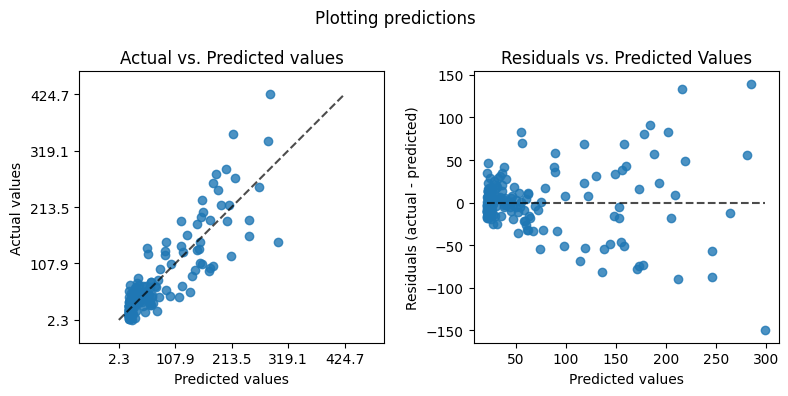

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

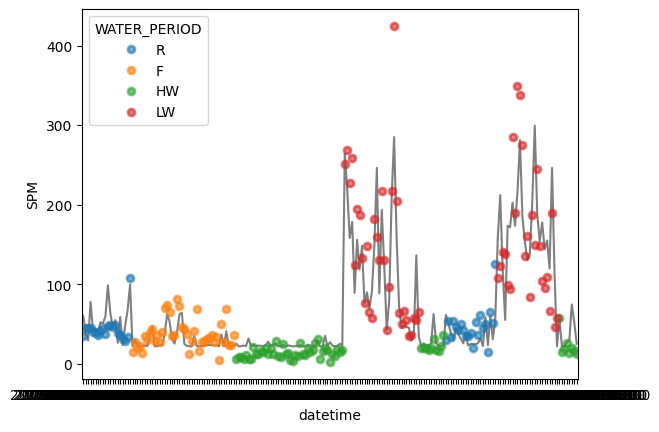

In [19]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Polynomial NIR + RED regression

In [20]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset[['nir_mean','red_mean']].copy()

In [21]:
model_fit = model_poly.fit(X, y)

In [22]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [ -2303.32860799   1648.35623702 246028.39293563 -48391.87989286
  -4484.52458659]
intercept: 3.9712072526901636


In [23]:
y_pred_model = model_fit.predict(X)

### Avaliação do modelo

In [24]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.7886871945999461, 'mae': 19.981608158784308, 'mse': 1071.0289263235618, 'mape': 0.410147602643196, 'exp_var': 0.7886871945999461}


Cross validation

In [25]:
cv_metrics = cv_model_metrics(model=model_poly,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.7590691230397797, 'mae': 18.172212854997525, 'mse': 962.5832041868132, 'mape': 0.38613860980857045, 'exp_var': 0.7633494822609339}


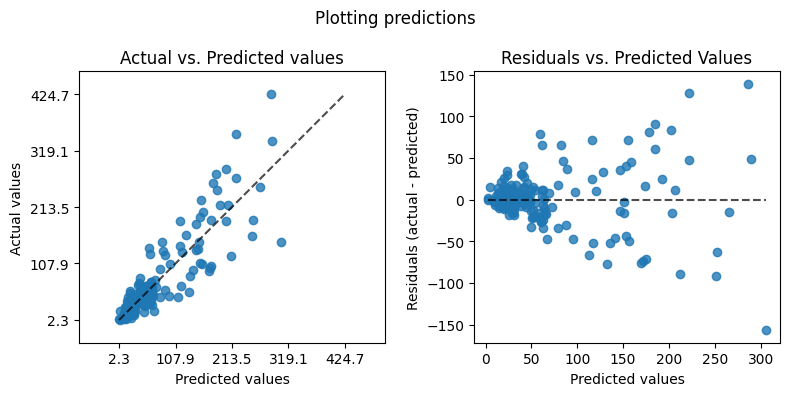

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

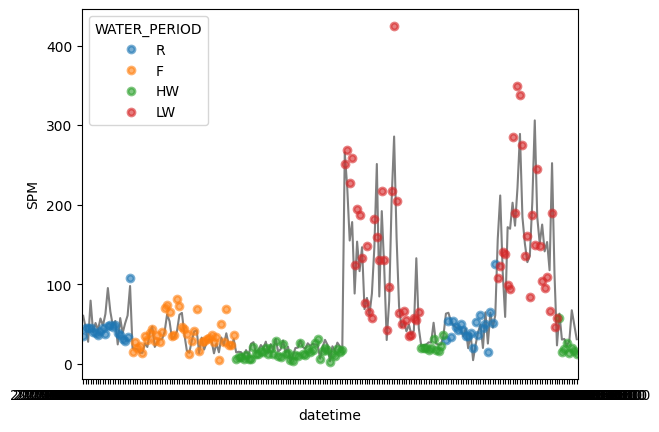

In [27]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Multiple linear regression

In [28]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [29]:
ols_fit = ols.fit(X, y)
y_pred_mlr = ols_fit.predict(X)

In [30]:
print(f"intercept: {ols_fit.intercept_}")
for n in range(len(X.columns)):

    print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

intercept: -15.12842522511545
blue_mean coef: -2076.3544379013306
green_mean coef: 1331.5317580110477
nir_mean coef: 5768.913549056313
red_mean coef: -261.462094398423


### Avaliação do modelo

In [31]:
metrics = model_metrics(y,y_pred_mlr)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.719092023460775, 'mae': 25.166131532262643, 'mse': 1423.7687486044497, 'mape': 0.623783931045546, 'exp_var': 0.719092023460775}


Cross validation

In [32]:
cv_metrics = cv_model_metrics(model=ols,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.6693987356284332, 'mae': 24.301081563527728, 'mse': 1305.7040816957483, 'mape': 0.6465228545097388, 'exp_var': 0.6757790542063805}


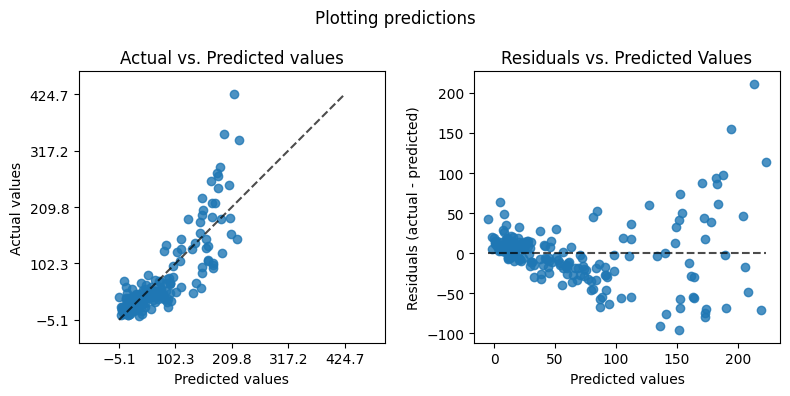

In [33]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

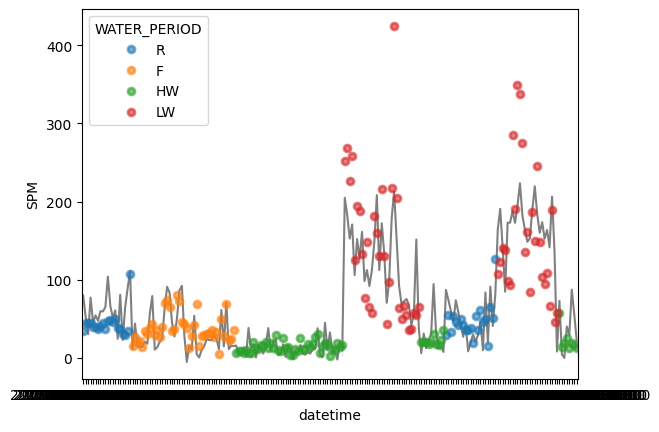

In [34]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_mlr,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')


### NIR / RED

In [35]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset['nir_mean']/ df_subset['red_mean']
X = np.array(X).reshape(-1, 1).copy()
X

array([[ 0.52758343],
       [ 0.37137743],
       [ 0.44493248],
       [ 0.46788177],
       [ 0.46650379],
       [ 0.36176143],
       [ 0.42709352],
       [ 0.40402139],
       [ 0.60264116],
       [ 0.4396702 ],
       [ 0.77699346],
       [ 0.46488753],
       [ 0.44351343],
       [ 0.55463135],
       [ 0.41768442],
       [ 0.5738336 ],
       [ 0.19403447],
       [ 0.43116177],
       [ 0.84862239],
       [ 0.64928322],
       [ 0.27170441],
       [ 0.82418839],
       [ 0.32452793],
       [ 0.37261813],
       [ 0.37261813],
       [ 0.27783891],
       [ 0.27022153],
       [ 0.37488643],
       [ 0.51164503],
       [ 0.24819718],
       [ 0.20745067],
       [ 0.23727677],
       [ 0.23326359],
       [ 0.38722437],
       [ 0.54058743],
       [ 0.51588811],
       [ 0.43643906],
       [ 0.25895128],
       [ 0.43396563],
       [ 0.54071045],
       [ 0.53610224],
       [ 0.23012523],
       [ 0.16221743],
       [ 0.3627246 ],
       [ 0.16122975],
       [ 0

In [36]:
model_fit = model_poly.fit(X, y)
y_pred_mlr = model_fit.predict(X)

#### Avaliação do modelo

In [37]:
metrics = model_metrics(y,y_pred_mlr)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.1776738141909714, 'mae': 41.05903632903345, 'mse': 4167.9212492939105, 'mape': 1.762363458698868, 'exp_var': 0.1776738141909714}


Cross validation

In [38]:
cv_metrics = cv_model_metrics(model=model_poly,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 34.52045955370983, 'mae': 68.35806585605616, 'mse': 134177.94193206006, 'mape': 13.880770030726008, 'exp_var': 33.55873816583717}


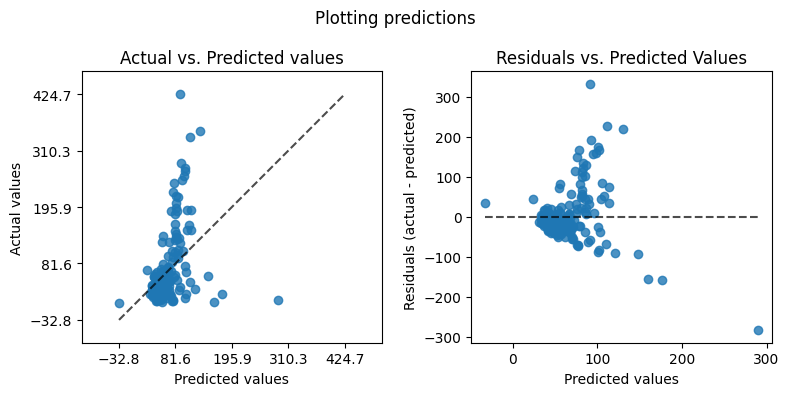

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

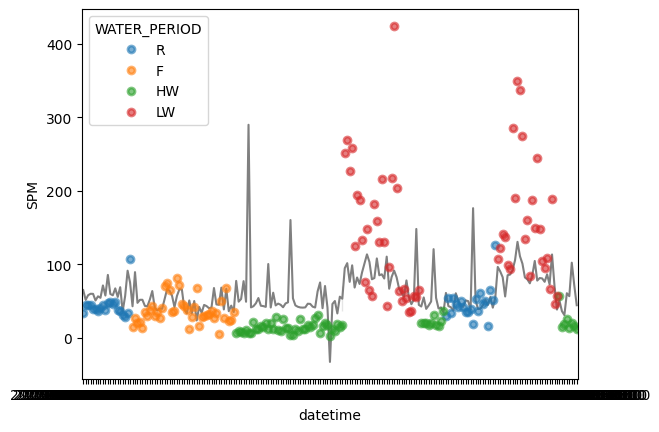

In [40]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_mlr,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')


## Polynomial multiple regression

In [41]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [42]:
model_fit = model_poly.fit(X, y)

In [43]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [   -817.23577142   -6531.16334319   -3368.67435232    6333.8219879
   66638.96021598 -544621.48605856 -126956.6292899   385200.07578481
  428358.6858635   254579.58343705 -251737.46922222  243169.84171234
 -134437.40343131  -64908.71259908]
intercept: 18.317026928454617


In [44]:
y_pred_model = model_fit.predict(X)

### Avaliação do modelo

In [45]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.8050219853326689, 'mae': 19.29152061783615, 'mse': 988.2368146620516, 'mape': 0.43975742042511057, 'exp_var': 0.8050219853326689}


Cross validation

In [46]:
cv_metrics = cv_model_metrics(model=model_poly,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.7681458210395196, 'mae': 18.043141480821923, 'mse': 991.4227053375951, 'mape': 0.37463450455925174, 'exp_var': 0.7728091174191176}


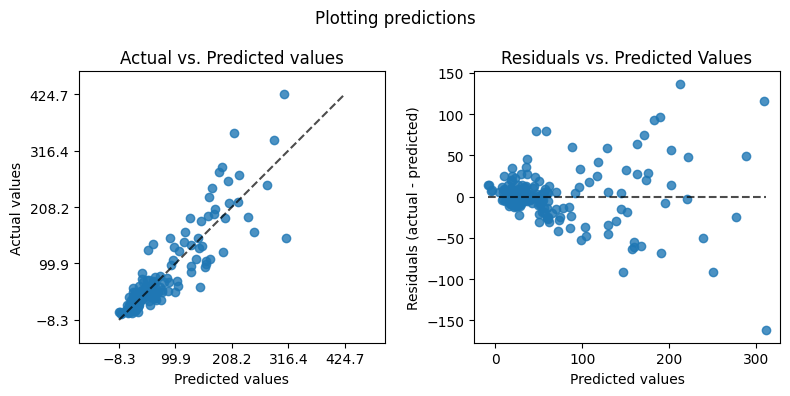

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

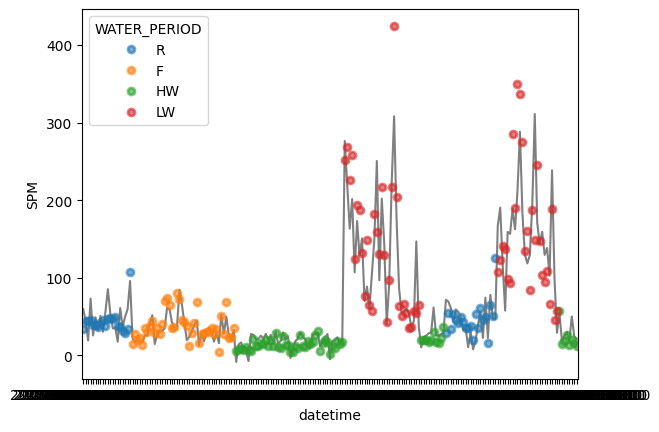

In [48]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Splines (multiple)

In [49]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()
# X = df_subset.drop('SPM',axis = 1).copy()

In [50]:
model_fit = model_splines.fit(X, y)

In [51]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [   -93.61548094   -347.46975899   -333.55535767   -343.03190946
   -353.24805829   -605.37063004   2076.29119539   2279.79992236
   2385.7380198    2401.32471724   2397.99428493   2418.44008088
   2830.80763233 -14714.10465754    146.77658618   -130.18210624
    -74.32064288    -67.13565779     58.47253078    217.3265743
   -150.93728435  -2241.02887035  -2382.06945827  -2361.36030223
  -2339.26554185  -2360.24654773  -2625.56784737  14309.53856781]
intercept: 410.5451672995291


In [52]:
y_pred_model = model_fit.predict(X)

### Avaliação do modelo

In [53]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.8417326926551553, 'mae': 17.93517625699129, 'mse': 802.1703367041995, 'mape': 0.3918279390643002, 'exp_var': 0.8417326926551553}


Cross validation

In [54]:
cv_metrics = cv_model_metrics(model=model_splines,X=X,y=y)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.7555398284082663, 'mae': 20.066227748922284, 'mse': 1038.2300141491796, 'mape': 0.42764438539509186, 'exp_var': 0.7625424399553105}


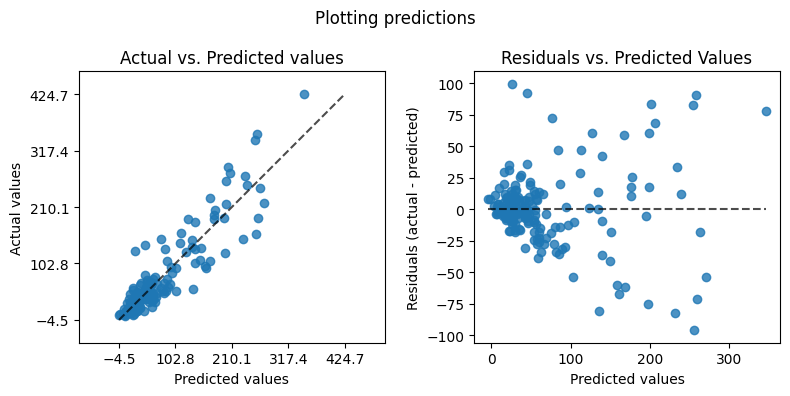

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

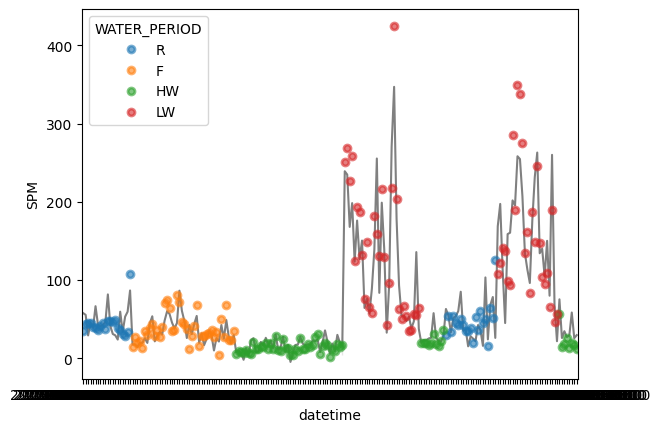

In [56]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Water Period

In [57]:
# separate data per water period
water_periods = df_subset.WATER_PERIOD.unique()
df_periods_list = []
for period in water_periods:
    df = df_subset.loc[df_subset['WATER_PERIOD'] == period].copy()
    # print(df.head())
    df_periods_list.append(df)

### NIR and RED polynomial regression

#### 2nd degree

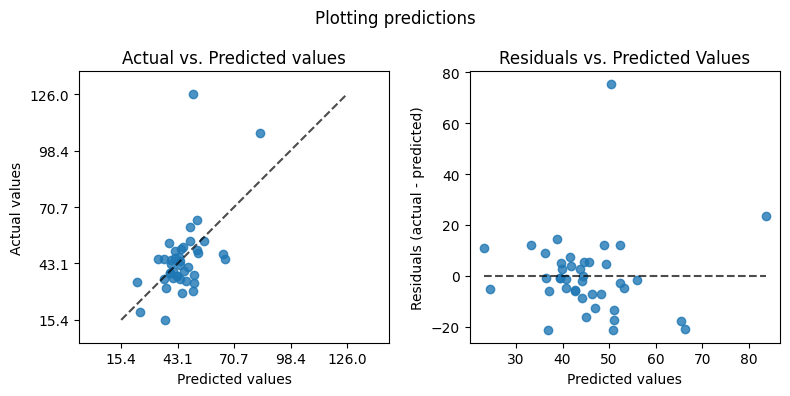

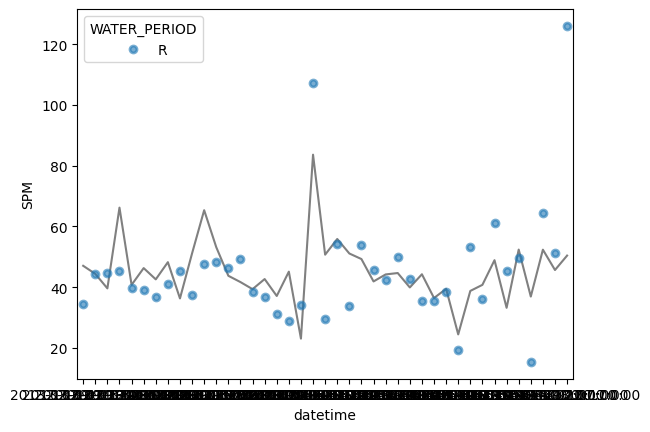

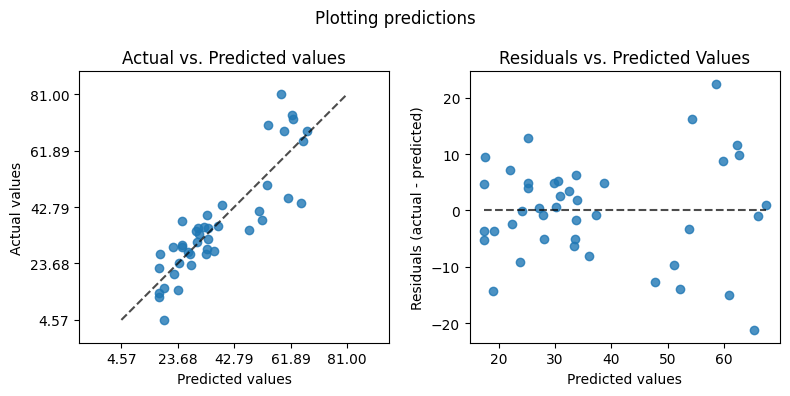

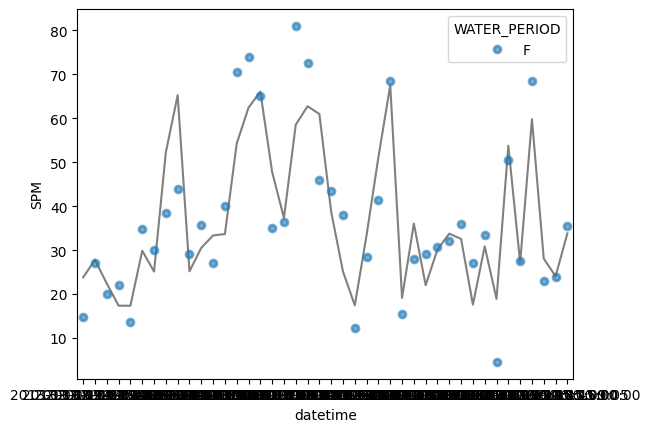

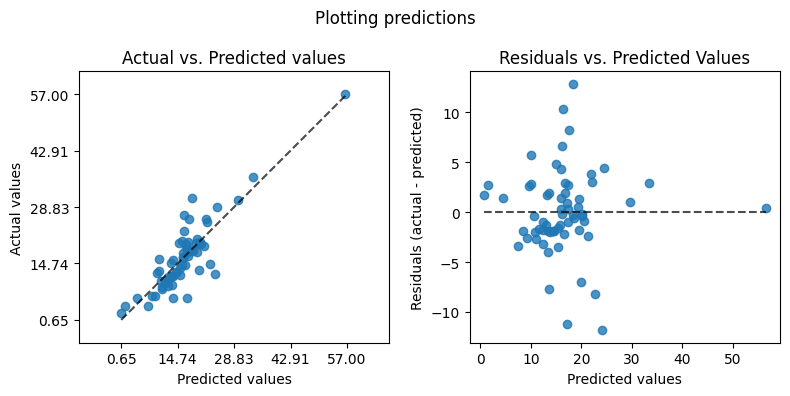

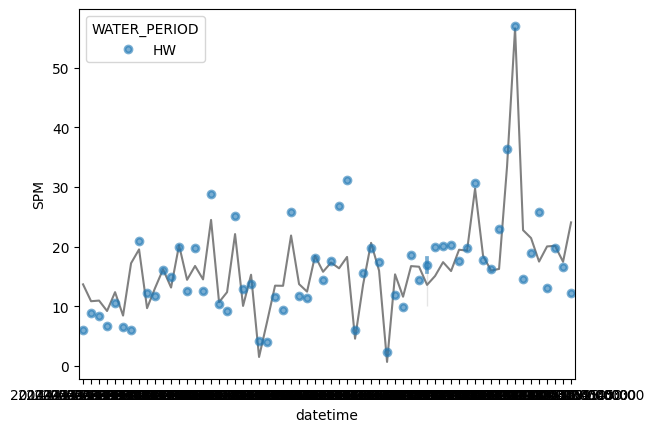

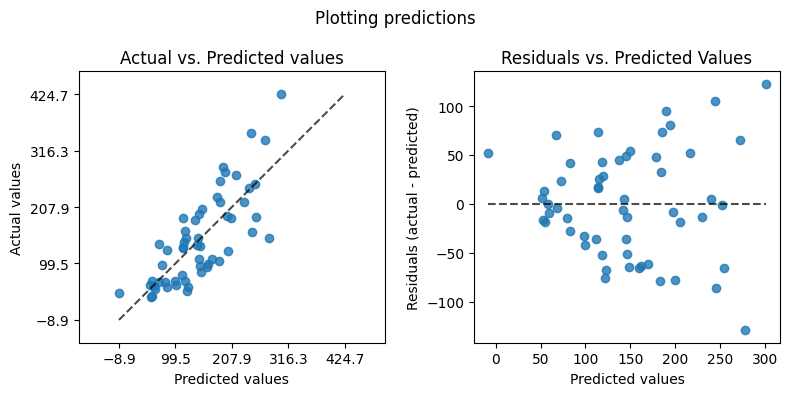

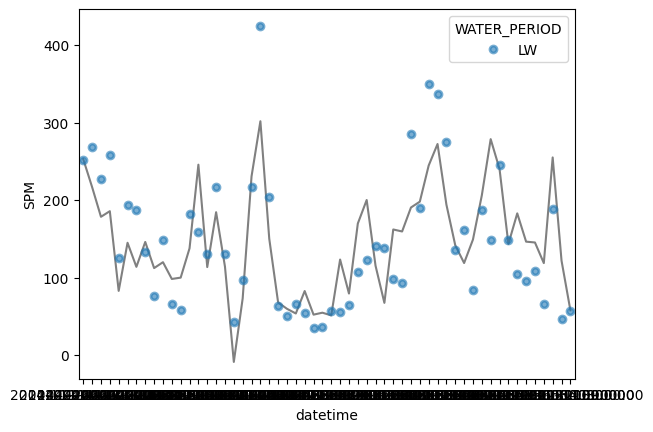

In [73]:
metrics_list=[]
cv_metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    X = dataset.loc[:,['nir_mean','red_mean']].copy()
    ols_fit = model_poly.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)


    intercept_list.append(ols_fit.named_steps['linear'].intercept_)


    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")

    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)

    cv_metrics = cv_model_metrics(model=ols,X=X,y=y)
    cv_metrics_list.append(cv_metrics)

    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [74]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")
dictionary_cv_metrics = dict(zip(water_periods, cv_metrics_list))
print(f"cv metrics: {dictionary_cv_metrics}")

coefficients: {'R': {'nir_mean': 8090.692128537962, 'red_mean': -958.446835368075}, 'F': {'nir_mean': -11334.62211667423, 'red_mean': 2910.8490842198808}, 'HW': {'nir_mean': -2642.8491534214754, 'red_mean': 2047.6067816889554}, 'LW': {'nir_mean': -11614.570954261428, 'red_mean': 64334.87604479339}}
intercepts: {'R': 17.32347165101116, 'F': 16.19568382766149, 'HW': 0.22371439082667877, 'LW': -456.59441465550924}
metrics: {'R': {'r2': 0.29866420478283084, 'mae': 10.102727560256703, 'mse': 250.40504372032686, 'mape': 0.235137554525595, 'exp_var': 0.29866420478283073}, 'F': {'r2': 0.764469936385376, 'mae': 6.808537561514724, 'mse': 76.72159648057143, 'mape': 0.25871371252949416, 'exp_var': 0.764469936385376}, 'HW': {'r2': 0.7620007656202507, 'mae': 3.0428867024017805, 'mse': 17.91847425325761, 'mape': 0.2547071512544565, 'exp_var': 0.7620007656202507}, 'LW': {'r2': 0.6103361151108878, 'mae': 44.37950390777599, 'mse': 2949.188404532323, 'mape': 0.38206401625692127, 'exp_var': 0.610336115110

### Multiple linear regession

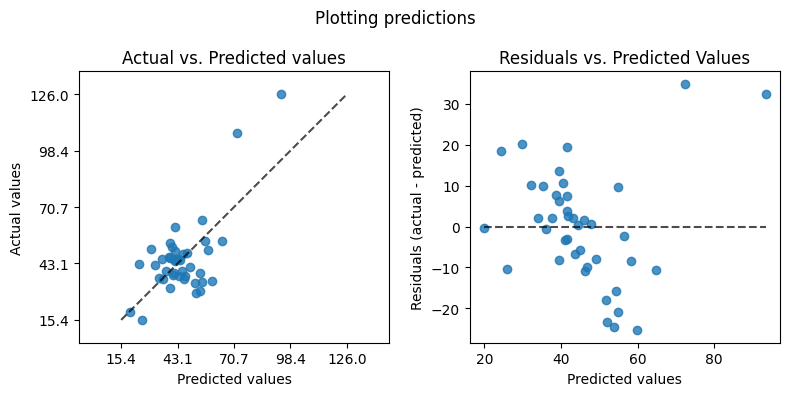

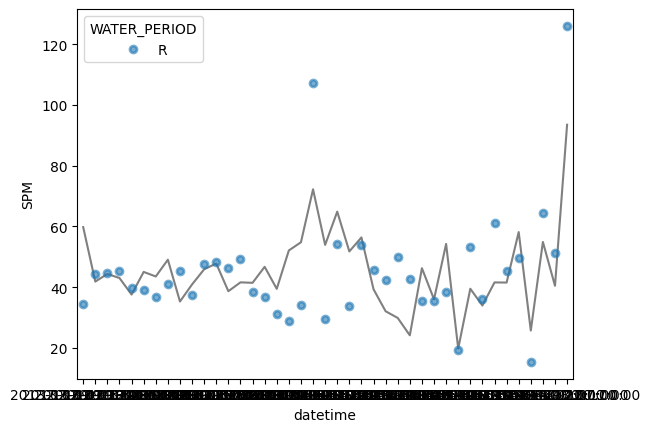

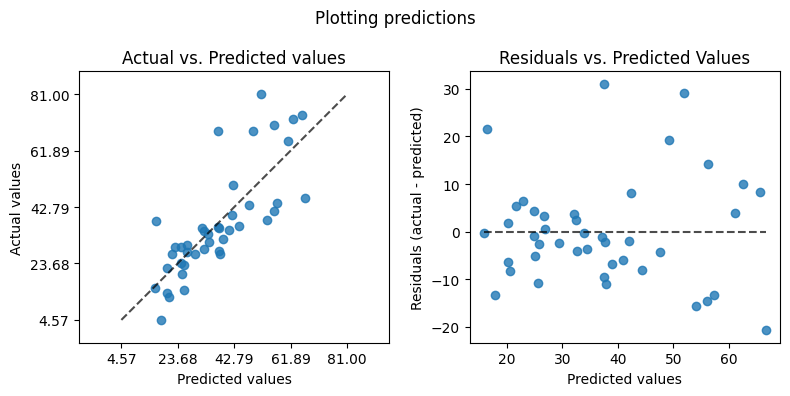

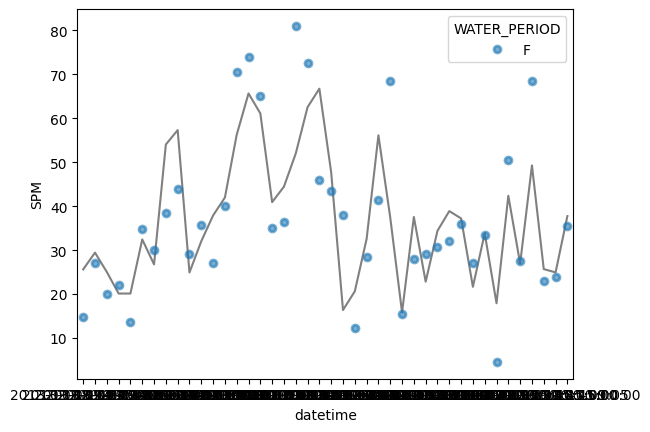

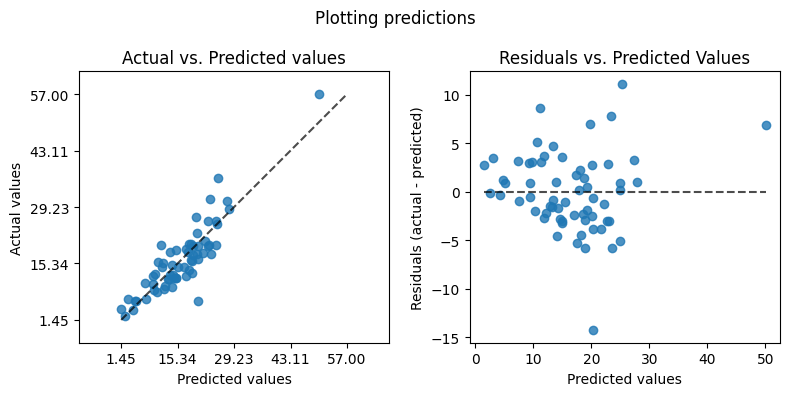

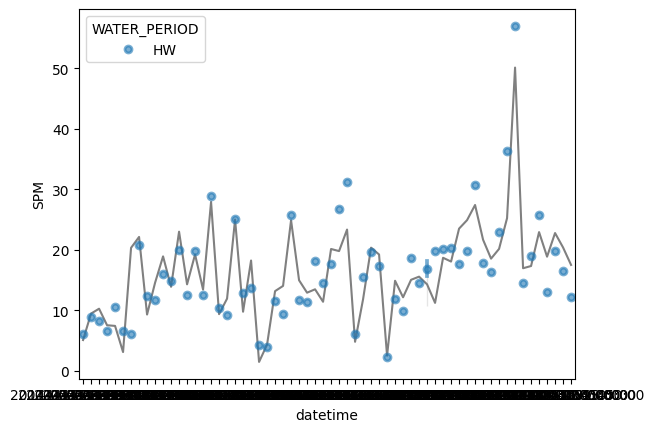

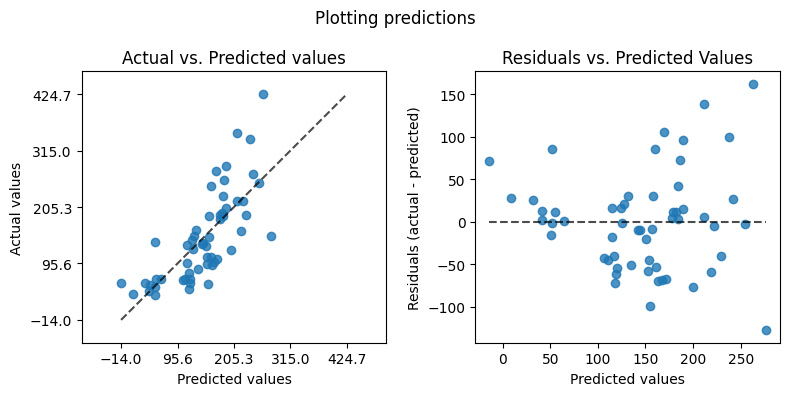

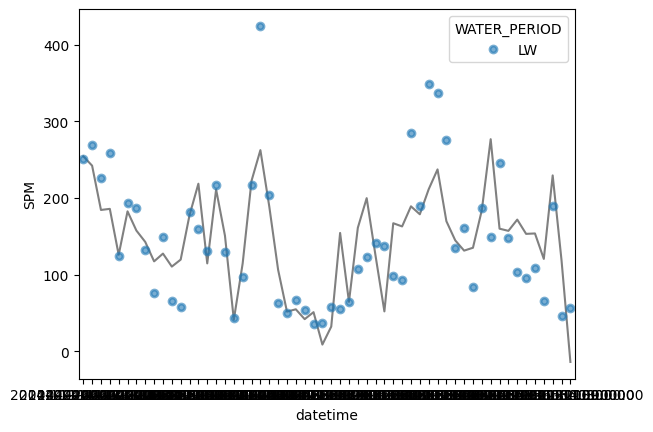

In [58]:
metrics_list=[]
coef_list = []
intercept_list = []
cv_metrics_list = []
for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = ols.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)


    intercept_list.append(ols_fit.intercept_)


    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")

    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)

    # cv_metrics = cv_model_metrics(model=ols,X=X,y=y)
    # cv_metrics_list.append(cv_metrics)
    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [59]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")
# dictionary_cv_metrics = dict(zip(water_periods, cv_metrics_list))
# print(f"cv metrics: {dictionary_cv_metrics}")

coefficients: {'R': {'blue_mean': 1828.8813950025658, 'green_mean': -8523.702748741096, 'nir_mean': 443.4956342561345, 'red_mean': 6403.980596336778}, 'F': {'blue_mean': -206.95979283826614, 'green_mean': -163.7355950519957, 'nir_mean': 1362.3645672377077, 'red_mean': 1342.9993780126931}, 'HW': {'blue_mean': -779.8745327614662, 'green_mean': -722.4409964025627, 'nir_mean': 728.569658140236, 'red_mean': 1699.5571338750667}, 'LW': {'blue_mean': 6992.68796368137, 'green_mean': -5695.735814942311, 'nir_mean': 8000.596656462308, 'red_mean': 789.3100495710428}}
intercepts: {'R': 29.941487119413082, 'F': 2.5117208769281163, 'HW': -1.1682843135705099, 'LW': -26.250153998339187}
metrics: {'R': {'r2': 0.47183359731858143, 'mae': 10.56023229958482, 'mse': 188.57661630417044, 'mape': 0.2490363716413982, 'exp_var': 0.47183359731858143}, 'F': {'r2': 0.6242984527357713, 'mae': 8.249858314463557, 'mse': 122.38107553647676, 'mape': 0.28491120104363316, 'exp_var': 0.6242984527357713}, 'HW': {'r2': 0.782

### Multiple polynomial regession

#### 2nd degree

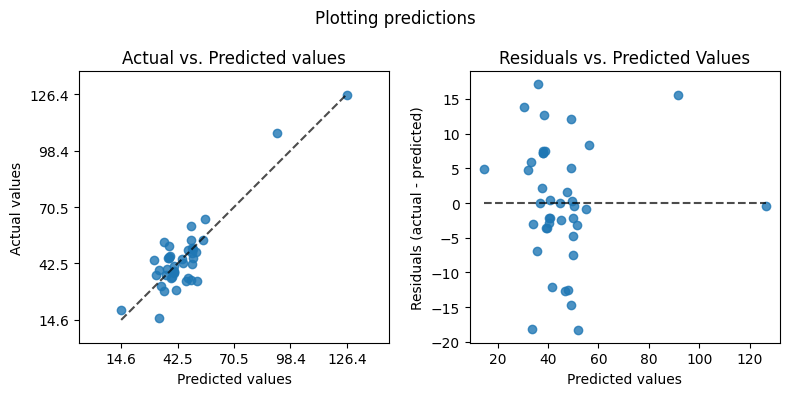

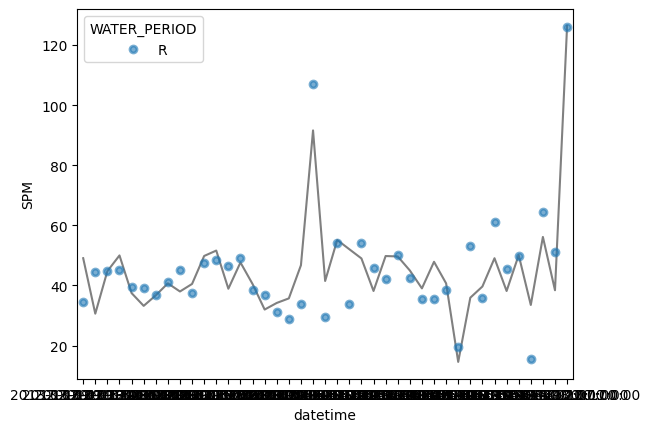

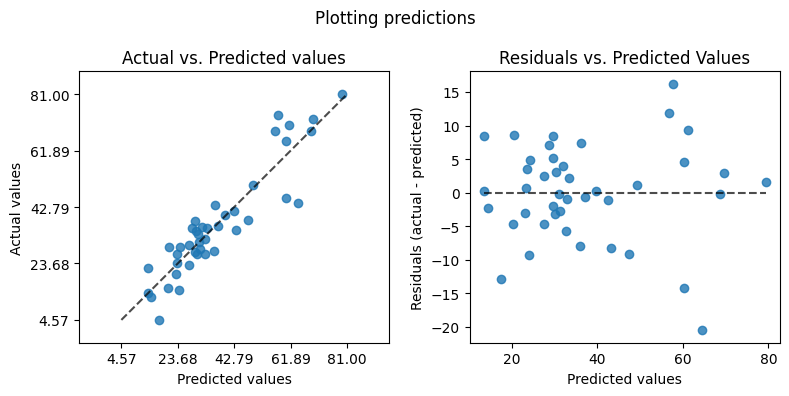

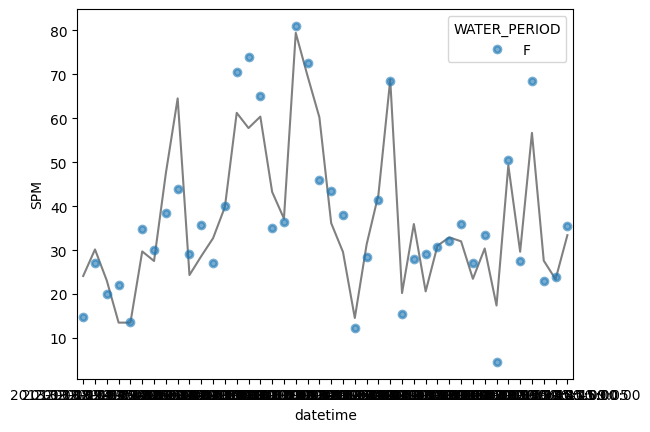

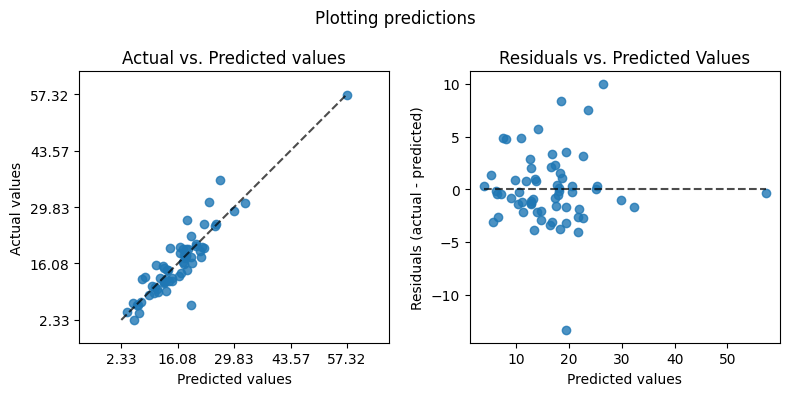

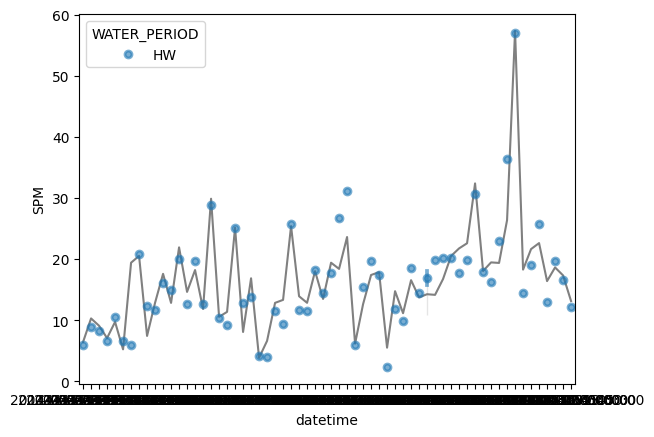

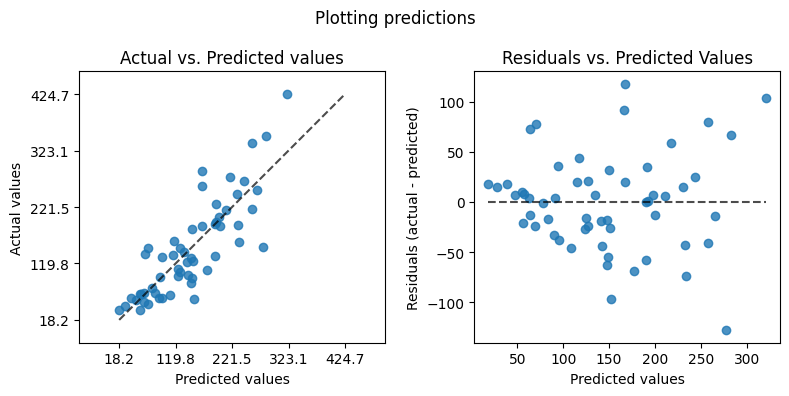

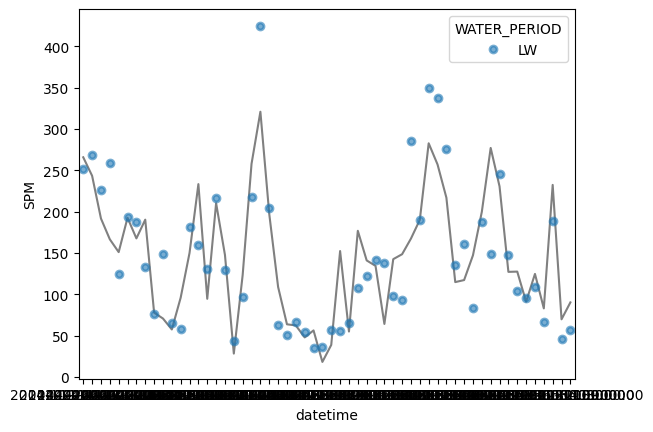

In [60]:
metrics_list=[]
cv_metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = model_poly.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)


    intercept_list.append(ols_fit.named_steps['linear'].intercept_)


    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")

    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)

    cv_metrics = cv_model_metrics(model=ols,X=X,y=y)
    cv_metrics_list.append(cv_metrics)

    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [61]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")
dictionary_cv_metrics = dict(zip(water_periods, cv_metrics_list))
print(f"cv metrics: {dictionary_cv_metrics}")

coefficients: {'R': {'blue_mean': 9397.458634743165, 'green_mean': -15642.598480528297, 'nir_mean': -3839.000846697629, 'red_mean': 7826.44767512563}, 'F': {'blue_mean': 16214.958769018504, 'green_mean': -11220.348595923173, 'nir_mean': -1767.2029738938154, 'red_mean': 3452.6088633501613}, 'HW': {'blue_mean': -2649.368512910364, 'green_mean': 5742.426363767621, 'nir_mean': 421.73215338540854, 'red_mean': -2286.816346600827}, 'LW': {'blue_mean': 33508.84732377354, 'green_mean': -70921.20896122433, 'nir_mean': 3065.245617150211, 'red_mean': 12940.350072456764}}
intercepts: {'R': 55.537688843904434, 'F': 27.756390494534326, 'HW': -1.8504265615980593, 'LW': 446.8648575314527}
metrics: {'R': {'r2': 0.7961615761741256, 'mae': 6.560751124794861, 'mse': 72.77850321926792, 'mape': 0.17610551726745965, 'exp_var': 0.7961615761741258}, 'F': {'r2': 0.8430499734768695, 'mae': 5.417670950394448, 'mse': 51.1249240021644, 'mape': 0.2187472731164805, 'exp_var': 0.8430499734768695}, 'HW': {'r2': 0.846229

#### 3rd degree

In [62]:
model_poly = Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                  ('linear', LinearRegression(positive=False))])

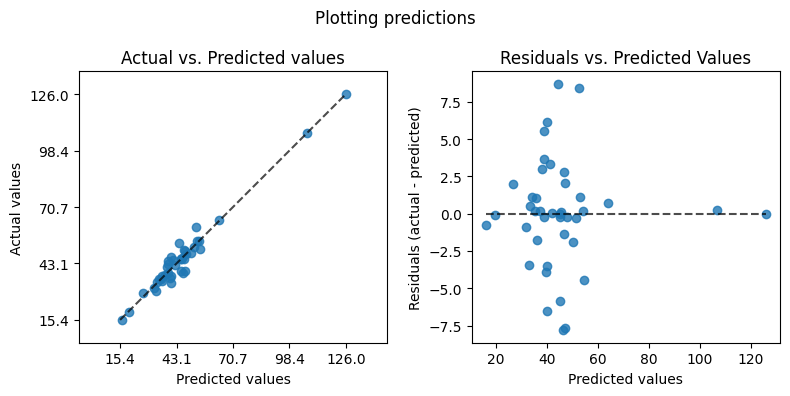

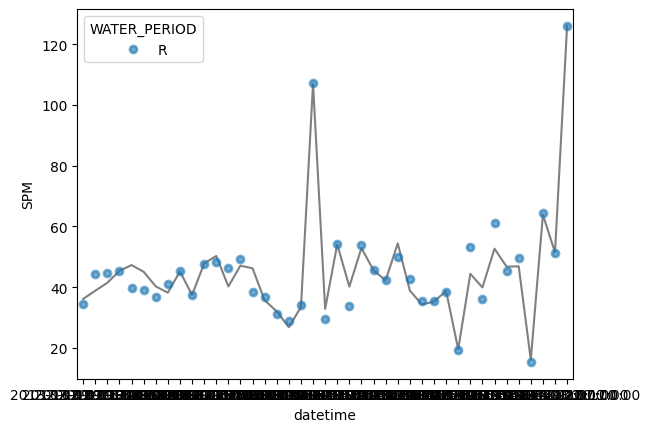

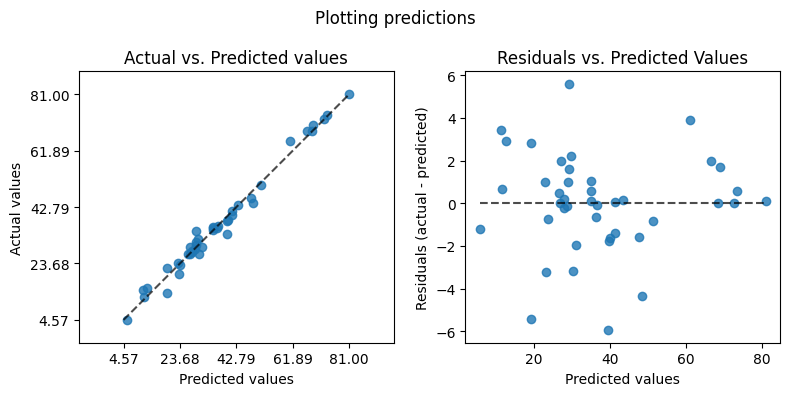

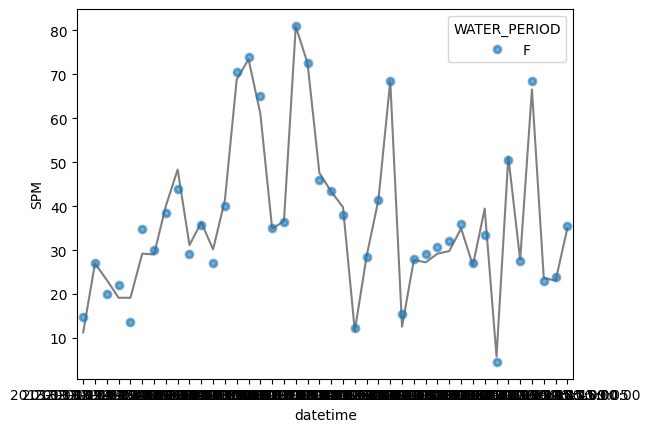

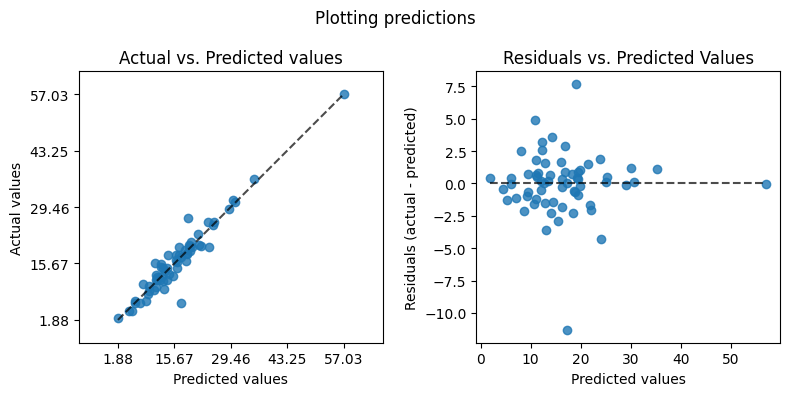

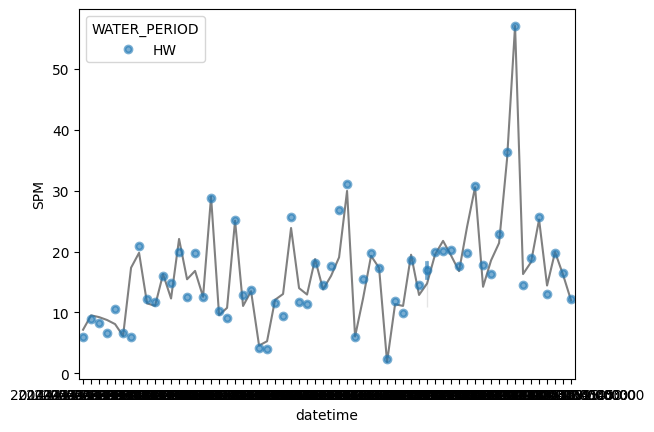

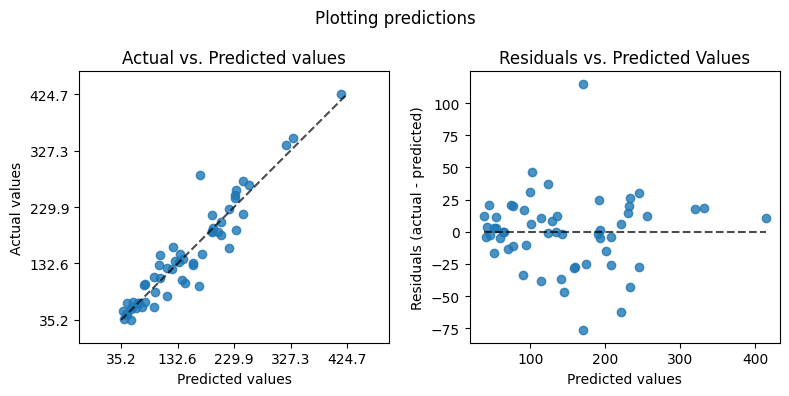

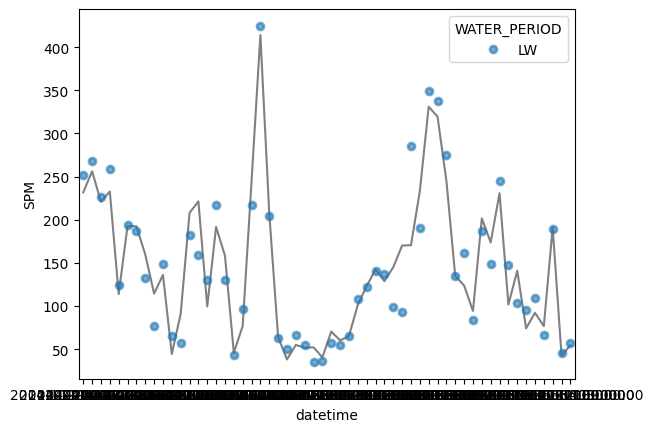

In [63]:
metrics_list=[]
coef_list = []
intercept_list = []
cv_metrics_list=[]

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = model_poly.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)


    intercept_list.append(ols_fit.named_steps['linear'].intercept_)


    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")

    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)

    cv_metrics = cv_model_metrics(model=model_poly,X=X,y=y)
    cv_metrics_list.append(cv_metrics)

    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [64]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")

dictionary_cv_metrics = dict(zip(water_periods, cv_metrics_list))
print(f"cv metrics: {dictionary_cv_metrics}")

coefficients: {'R': {'blue_mean': 31983.655236692815, 'green_mean': -96625.76738008807, 'nir_mean': 15494.162425351486, 'red_mean': 75082.62314029102}, 'F': {'blue_mean': 91847.89350554963, 'green_mean': -11183.490853029318, 'nir_mean': -72349.97948234262, 'red_mean': 16369.986763677987}, 'HW': {'blue_mean': 12265.763389283986, 'green_mean': -32095.20160885603, 'nir_mean': -3071.9035532490198, 'red_mean': 16470.58469516287}, 'LW': {'blue_mean': 1289161.5590535514, 'green_mean': -2050949.9837686631, 'nir_mean': 151645.93950488803, 'red_mean': 693605.909358174}}
intercepts: {'R': -109.74210872063135, 'F': -130.03155823967444, 'HW': 25.819536490542585, 'LW': 3684.7640286378955}
metrics: {'R': {'r2': 0.9633833813396983, 'mae': 2.487144469088208, 'mse': 13.073603342439139, 'mape': 0.059944933379220515, 'exp_var': 0.9633833813396983}, 'F': {'r2': 0.9840095536651995, 'mae': 1.629511618698812, 'mse': 5.208730267445244, 'mape': 0.06543675321368699, 'exp_var': 0.9840095536651995}, 'HW': {'r2': 0

## multiple spline regression

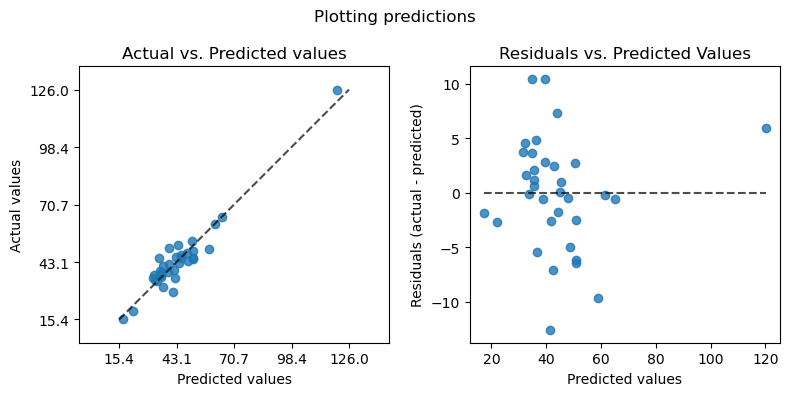

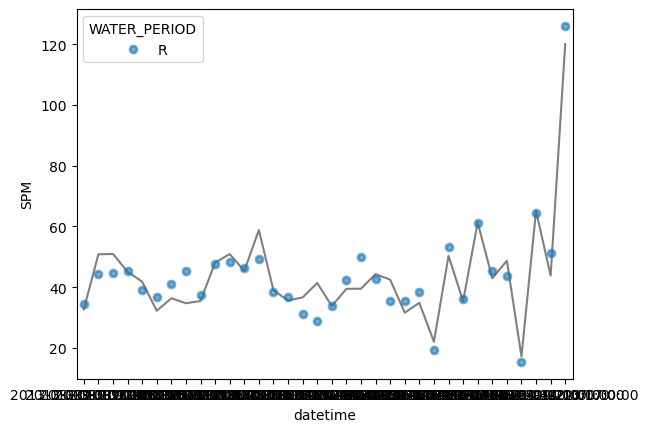

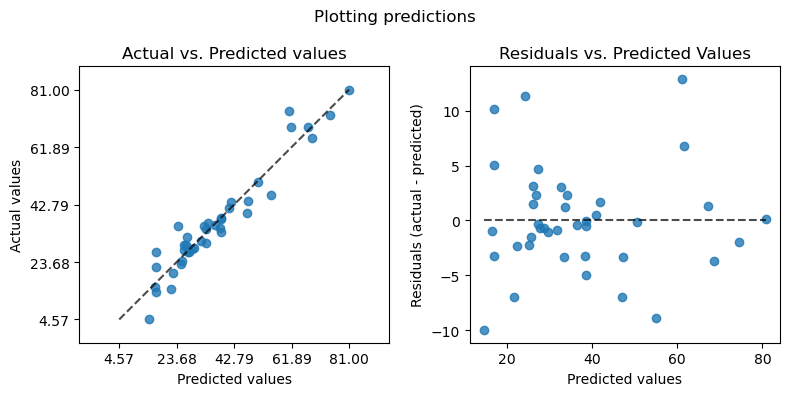

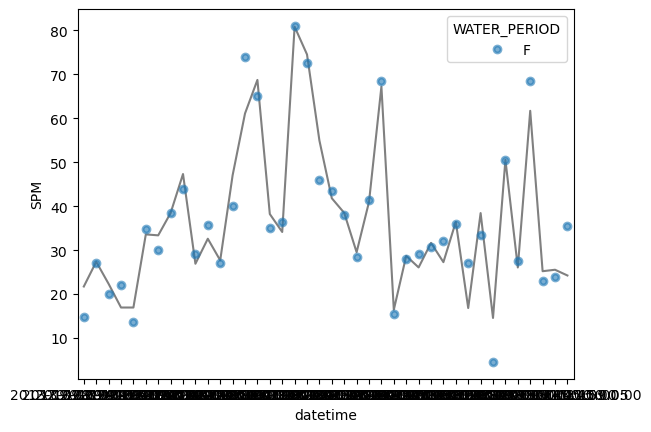

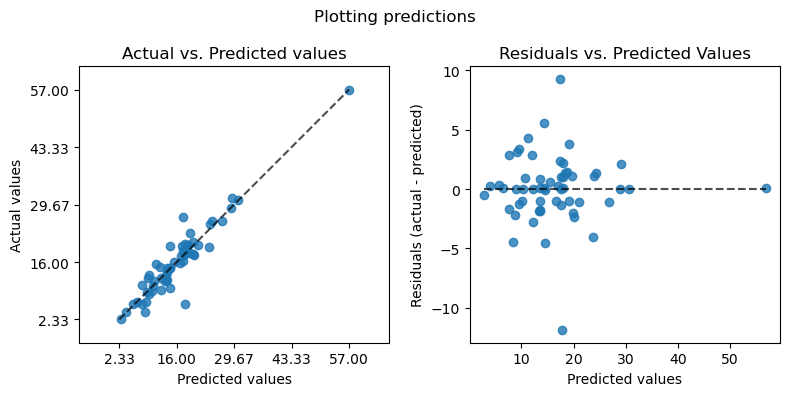

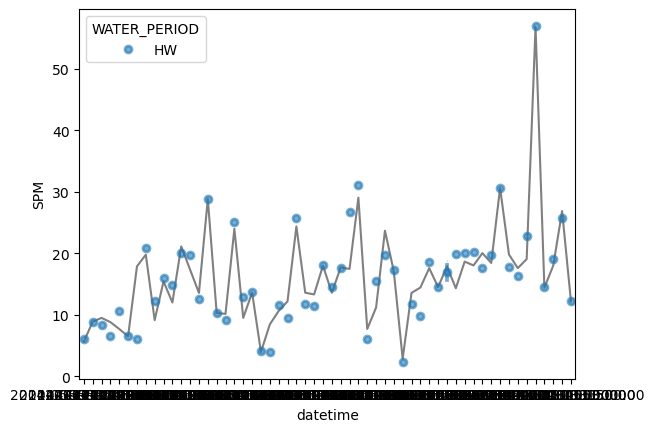

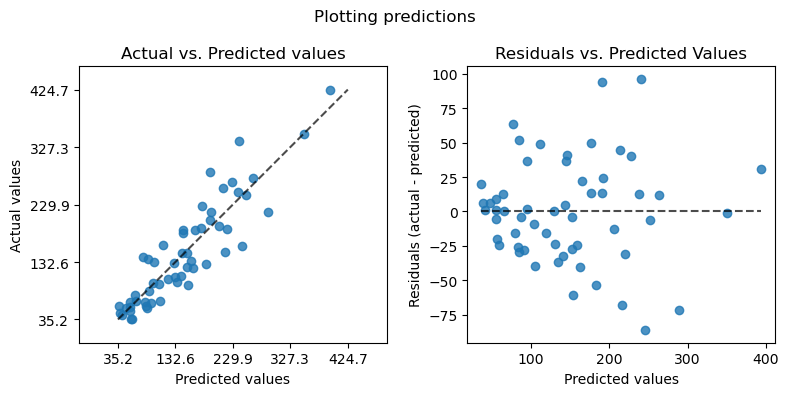

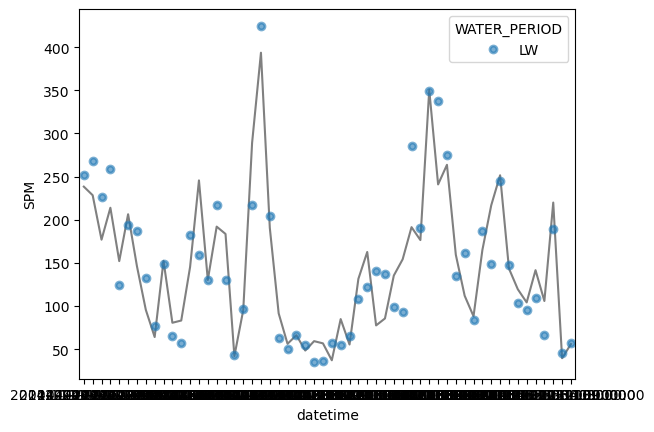

In [ ]:
metrics_list=[]
cv_metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = model_splines.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)


    intercept_list.append(ols_fit.named_steps['linear'].intercept_)


    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")

    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)

    cv_metrics = cv_model_metrics(model =model_splines,X=X,y=y )
    cv_metrics_list.append(cv_metrics)

    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [ ]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")

dictionary_cv_metrics = dict(zip(water_periods, cv_metrics_list))
print(f"cv metrics: {dictionary_cv_metrics}")

coefficients: {'R': {'blue_mean': 630.5407685775639, 'green_mean': 9.609176173721847, 'nir_mean': 235.56912015676517, 'red_mean': 194.43220613823487}, 'F': {'blue_mean': -218.05317499889293, 'green_mean': 87.81193442577246, 'nir_mean': -7.45050062889865, 'red_mean': 40.904151507533186}, 'HW': {'blue_mean': 120564794056572.81, 'green_mean': 120564794056622.66, 'nir_mean': 120564794056577.31, 'red_mean': 120564794056580.11}, 'LW': {'blue_mean': 1706.166199214205, 'green_mean': -135.16466873144728, 'nir_mean': -371.2095085689407, 'red_mean': -197.91756020837036}}
intercepts: {'R': 989.3000612478784, 'F': 5.0689072110051185, 'HW': 165734311557441.62, 'LW': 718.4775487892147}
metrics: {'R': {'r2': 0.9137761392684446, 'mae': 3.864169975421721, 'mse': 25.730776991678454, 'mape': 0.09655567754143174, 'exp_var': 0.9137761392684446}, 'F': {'r2': 0.9236524865400835, 'mae': 3.4184277187682044, 'mse': 22.80225155266641, 'mape': 0.1528622233050676, 'exp_var': 0.9236524865400835}, 'HW': {'r2': 0.8932

## Bands & Water Period

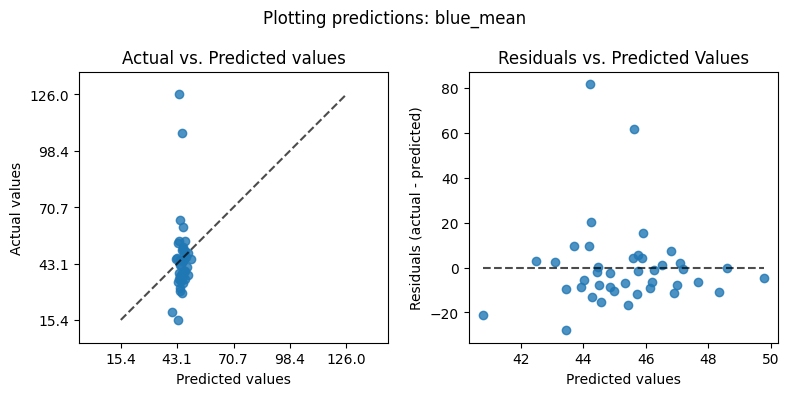

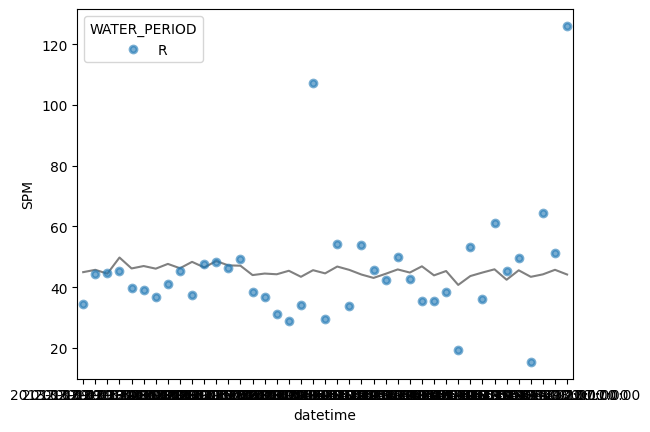

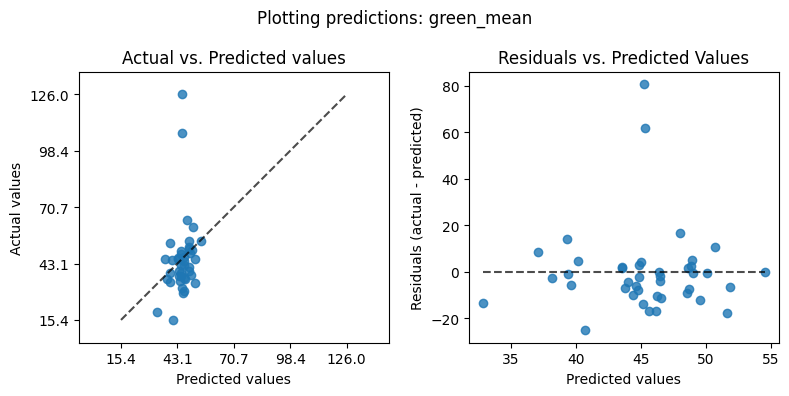

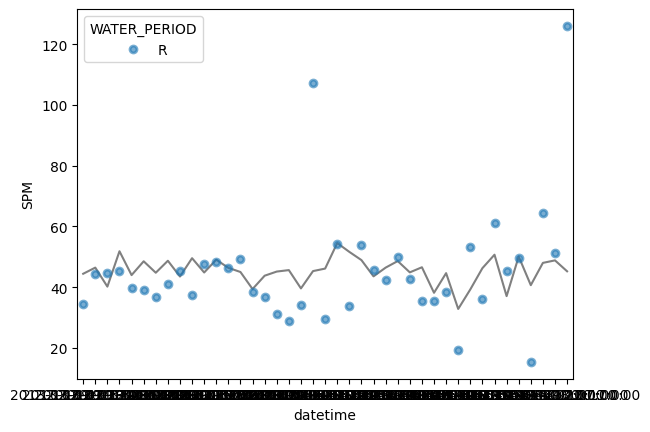

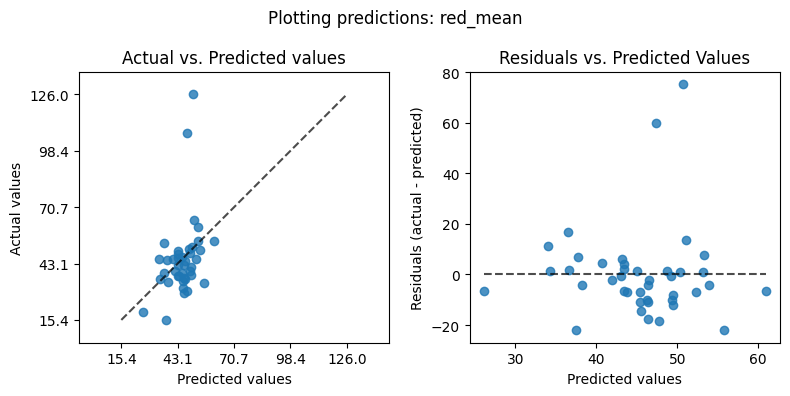

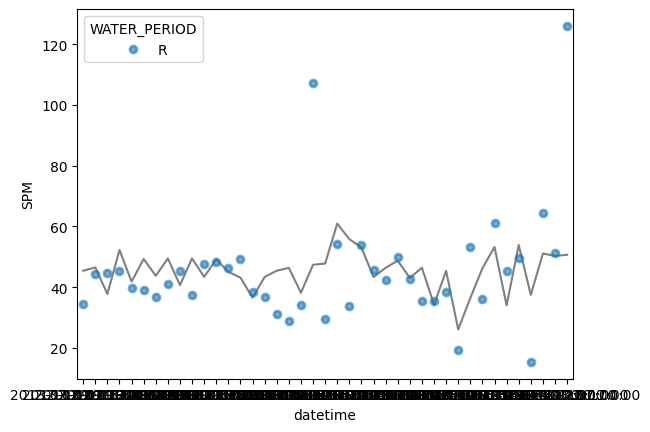

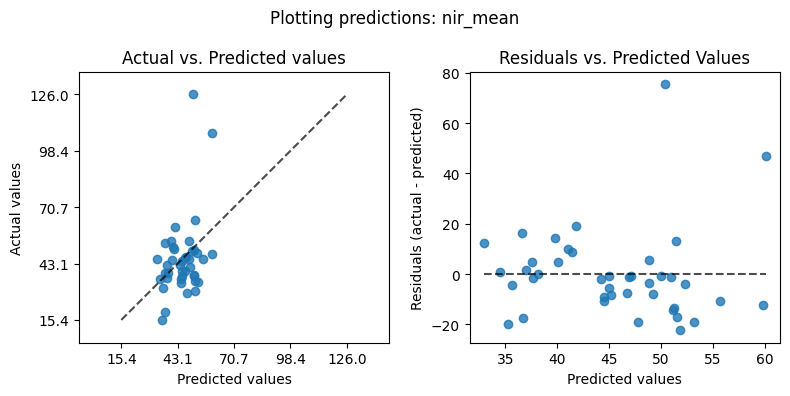

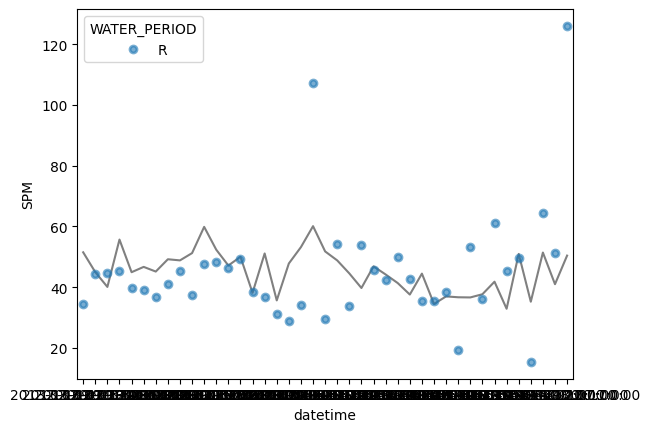

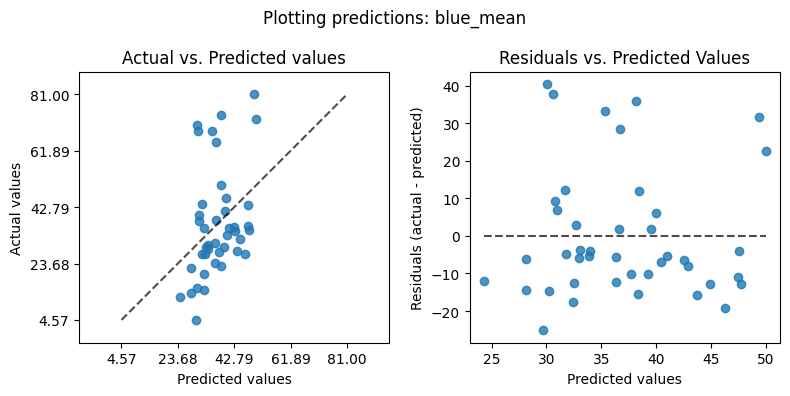

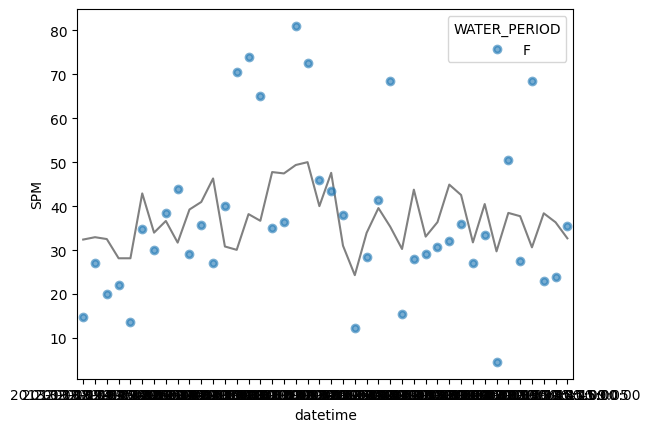

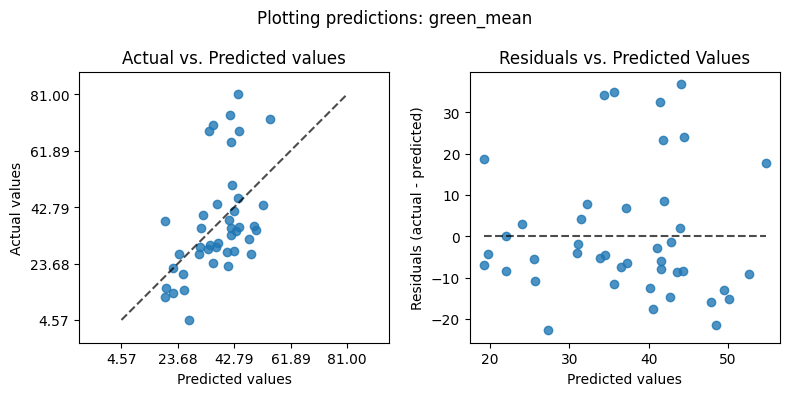

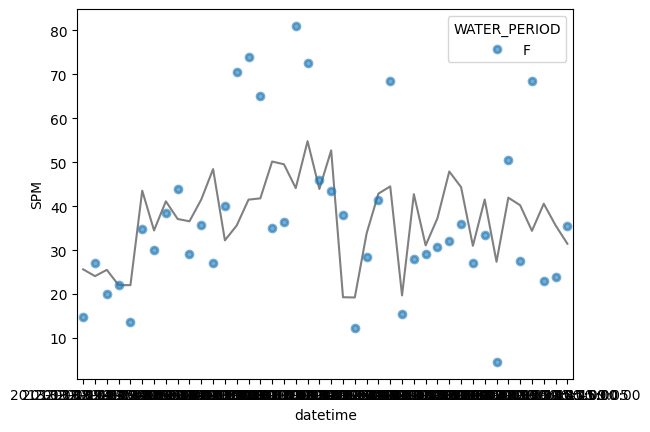

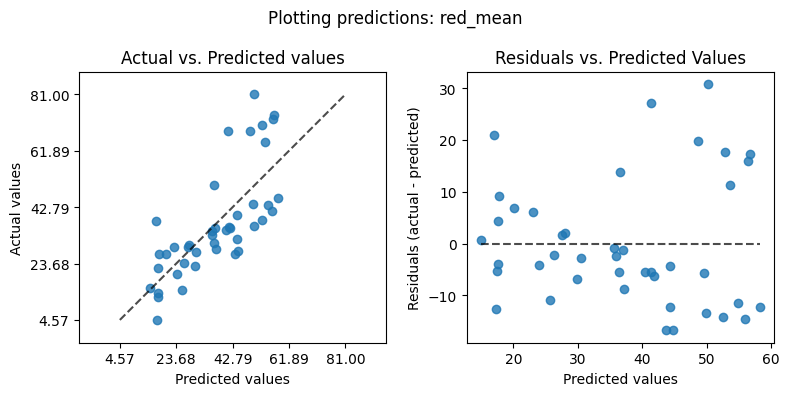

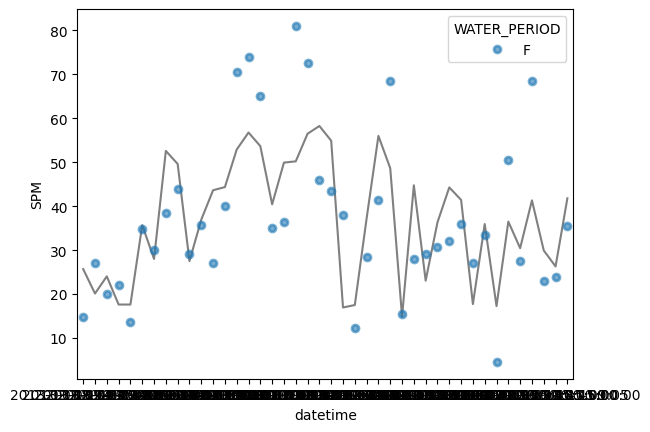

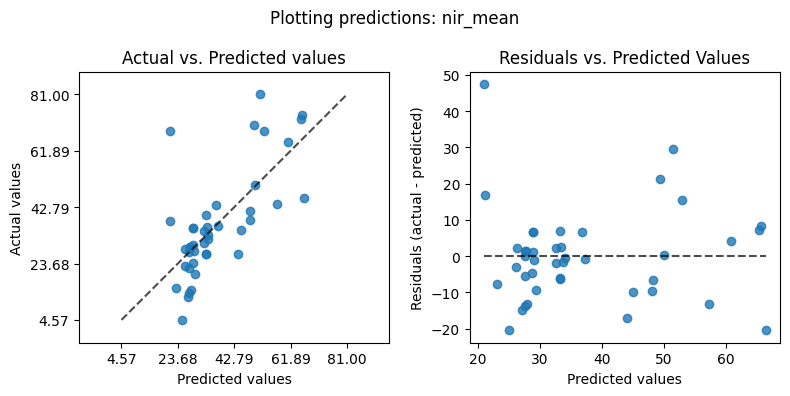

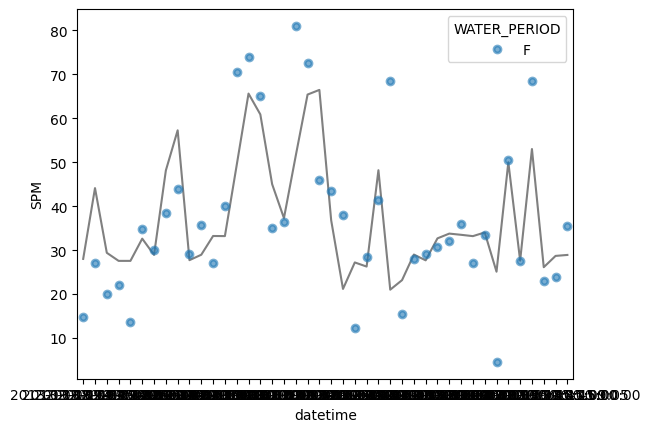

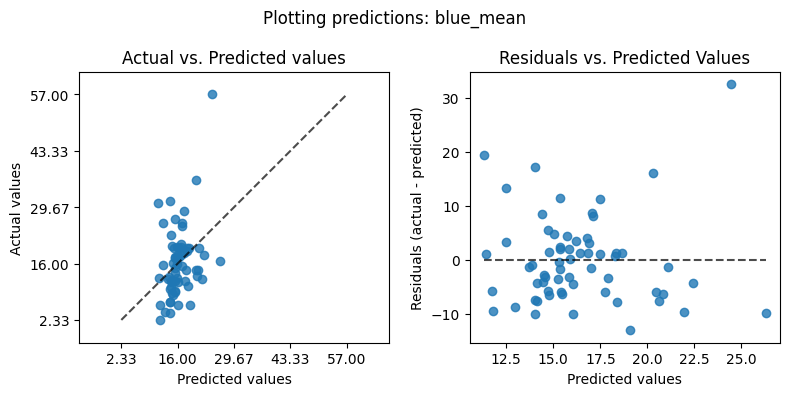

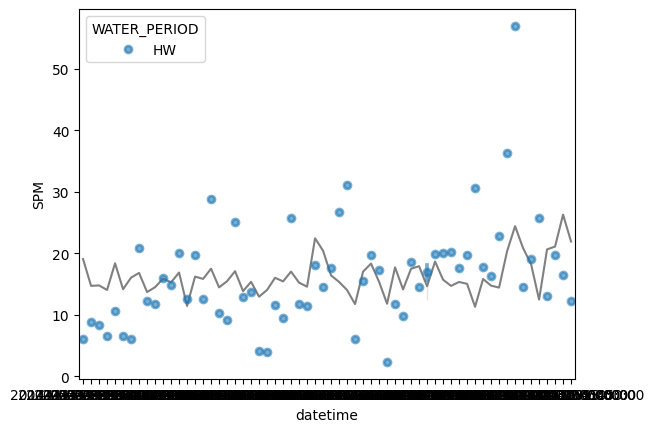

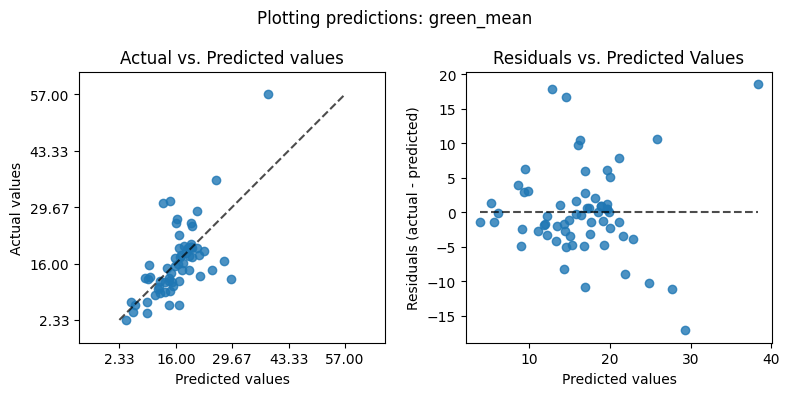

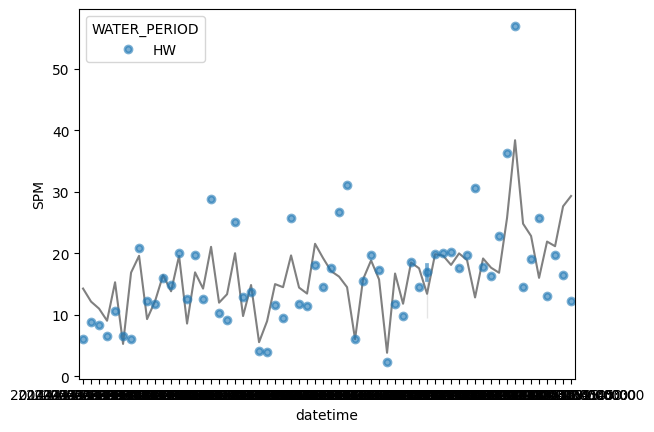

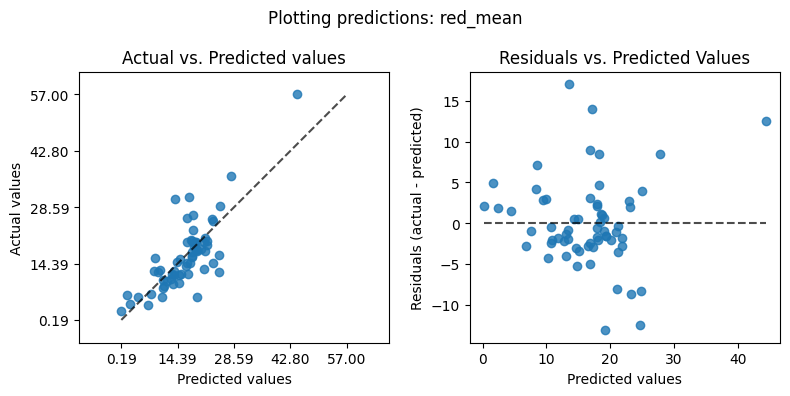

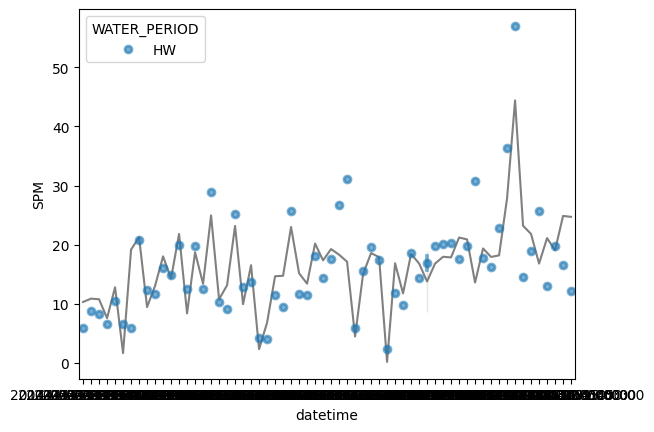

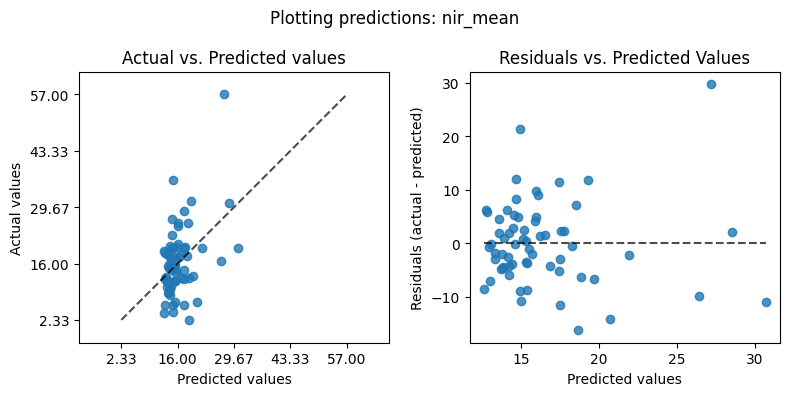

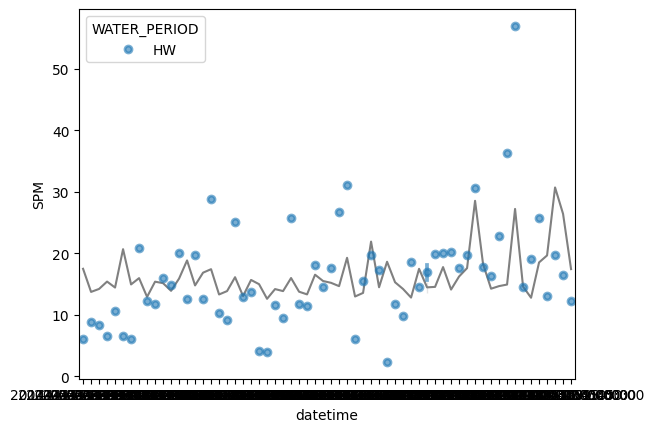

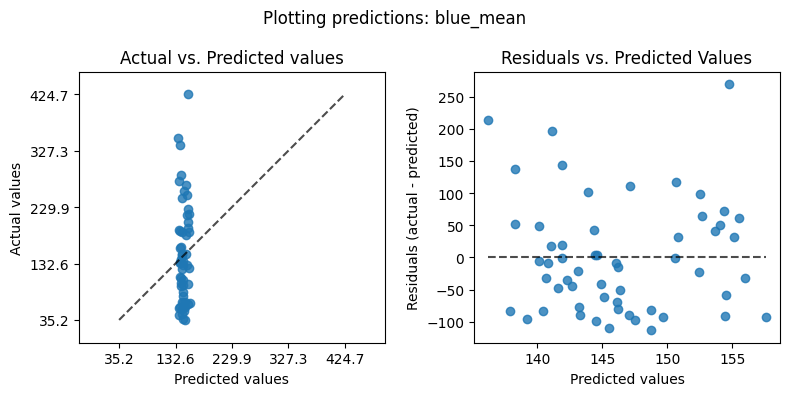

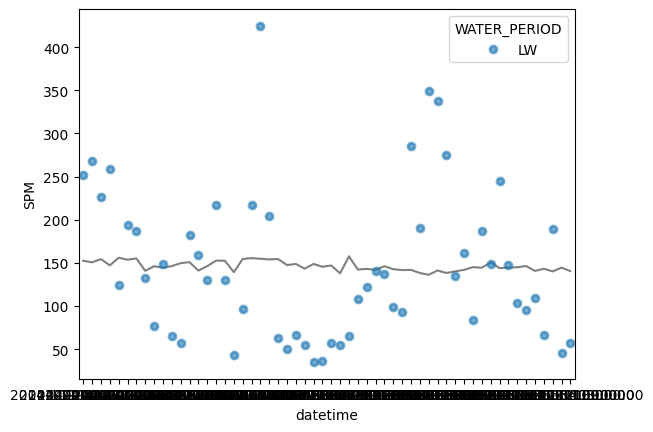

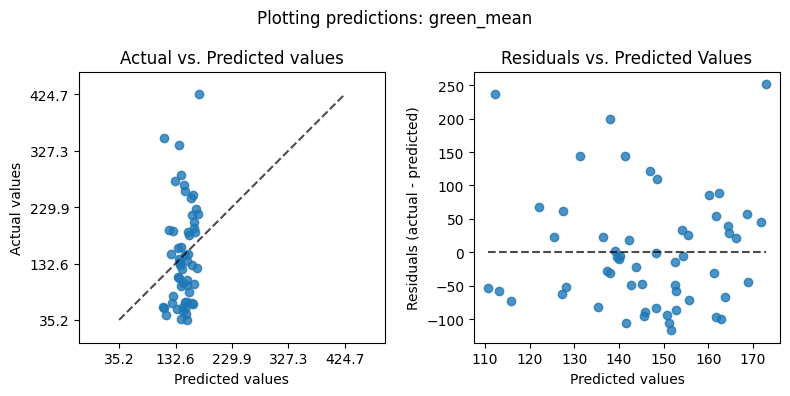

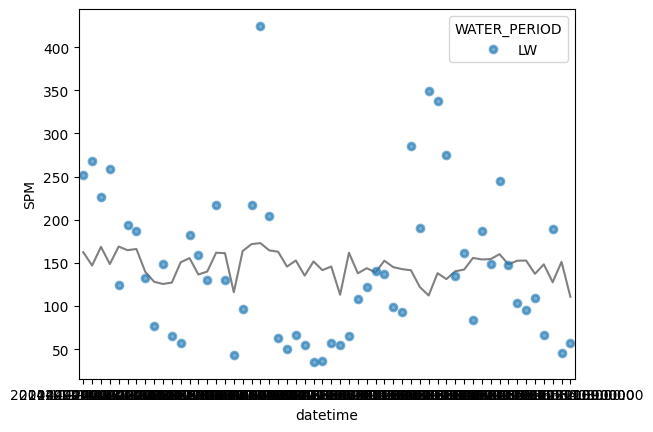

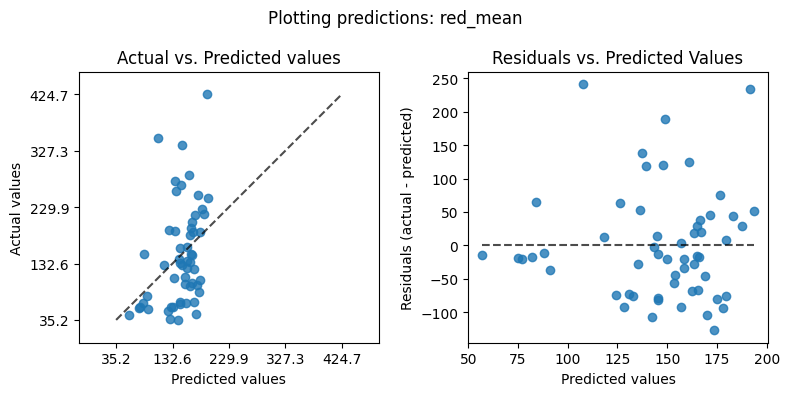

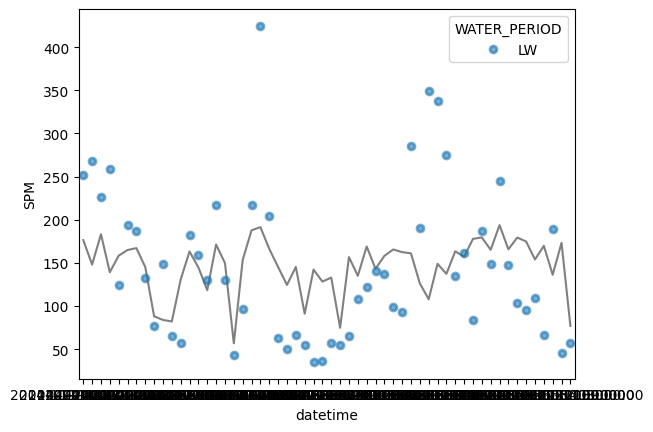

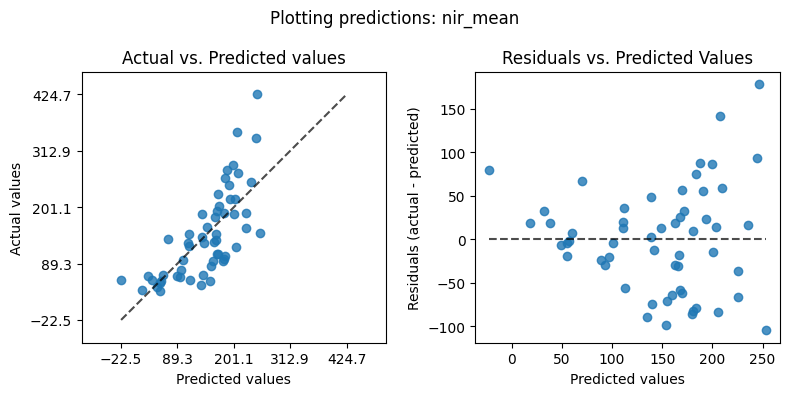

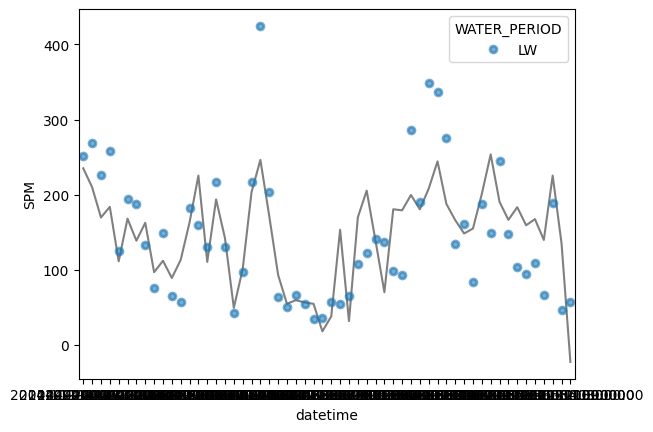

In [65]:
metrics_list=[]
cv_metrics_list=[]
coef_list = []
intercept_list = []
bands = ['blue_mean','green_mean','red_mean','nir_mean']
for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()

    for band in bands:

        X = np.array(dataset[band]).reshape(-1, 1).copy()
        ols_fit = ols.fit(X, y)
        y_pred_mlr = ols_fit.predict(X)


        intercept_list.append(ols_fit.intercept_)


        # print('equation')
        # print(f"intercept: {ols_fit.intercept_}")

        # for n in range(len(X.columns)):

        #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

        coef_dic = {band:ols_fit.coef_}

        coef_list.append(coef_dic)

        metrics = model_metrics(y,y_pred_mlr)
        metrics_list.append(metrics)

        cv_metrics = cv_model_metrics(model = ols,X=X,y=y)
        cv_metrics_list.append(cv_metrics)
        # print(' ')
        # print('Metrics:')
        # print(metrics)
        # print(' ')

        fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
        PredictionErrorDisplay.from_predictions(
            y,
            y_pred=y_pred_mlr,
            kind="actual_vs_predicted",
            ax=axs[0]
        )
        axs[0].set_title("Actual vs. Predicted values")
        PredictionErrorDisplay.from_predictions(
            y,
            y_pred=y_pred_mlr,
            kind="residual_vs_predicted",
            ax=axs[1]
        )
        axs[1].set_title("Residuals vs. Predicted Values")
        fig.suptitle(f"Plotting predictions: {band}")
        plt.tight_layout()
        plt.show()

        sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
        sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [66]:
metrics_list
cv_metrics_list
coef_list
intercept_list
bands
water_periods

array(['R', 'F', 'HW', 'LW'], dtype=object)

In [67]:
dic_list = []
for i in range(len(water_periods)):
    for j in range(len(bands)):
        dic_list.append(dict(band = bands[j],
                   period = water_periods[i],
                   coefficients = coef_list[(i+1)*(j)],
                   intercept = intercept_list[(i+1)*(j)],
                   metrics = metrics_list[(i+1)*(j)],
                   cv_metrics = cv_metrics_list[(i+1)*(j)]))


In [68]:
print(dic_list)

[{'band': 'blue_mean', 'period': 'R', 'coefficients': {'blue_mean': array([287.51828885])}, 'intercept': 40.697973023355416, 'metrics': {'r2': 0.008203637609838554, 'mae': 11.143099812519758, 'mse': 354.11113075879365, 'mape': 0.26338960310474424, 'exp_var': 0.008203637609838332}, 'cv_metrics': {'r2': 0.36304880346239005, 'mae': 12.874538750143156, 'mse': 544.0761137565424, 'mape': 0.26537705815378676, 'exp_var': 0.07513035917993005}}, {'band': 'green_mean', 'period': 'R', 'coefficients': {'green_mean': array([546.25680827])}, 'intercept': 30.553971971574313, 'metrics': {'r2': 0.05205485348042971, 'mae': 10.528645520029828, 'mse': 338.4544856792926, 'mape': 0.24377435630938224, 'exp_var': 0.0520548534804296}, 'cv_metrics': {'r2': 0.13067660570080647, 'mae': 12.045388966287494, 'mse': 498.3442070373737, 'mape': 0.233921929341865, 'exp_var': 0.13418970197229171}}, {'band': 'red_mean', 'period': 'R', 'coefficients': {'red_mean': array([653.93472031])}, 'intercept': 23.818350825926338, 'me